,requests,Temperature,Precipitation,WindSpeed
2015-09-01 00:00:00,709,16.0,0.0,17.0
2015-09-01 01:00:00,480,16.0,0.0,17.0
2015-09-01 02:00:00,498,15.0,0.0,18.0
2015-09-01 03:00:00,567,15.0,0.0,18.0
2015-09-01 04:00:00,361,16.0,0.0,15.0


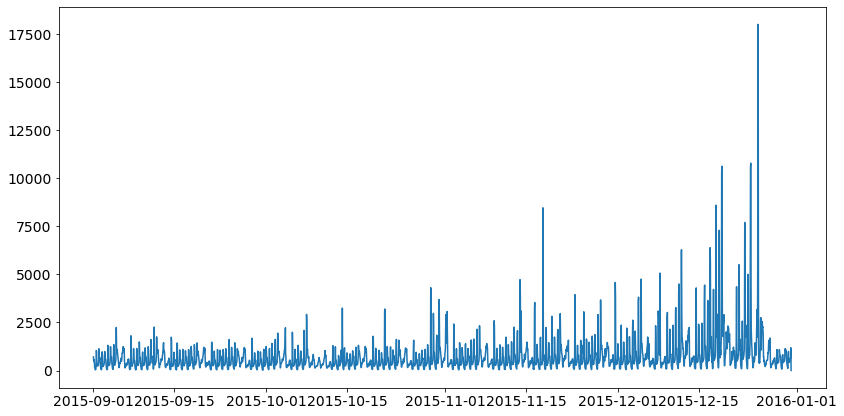

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

rcParams['figure.figsize'] = 12, 6
rcParams.update({'figure.autolayout': True})      # fixes clipping pics!
matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=22)
plt.gcf().autofmt_xdate()                         # fixes x-ticks

warnings.filterwarnings('ignore')

df = pd.read_csv("../../data.csv")                     
df.request_date = pd.to_datetime(df.request_date)    # convert string index to datetime (for decomposition)
df.set_index('request_date', inplace=True)
df.index = pd.date_range(df.index[0], df.index[-1], freq='H')
plt.plot(df['requests'])
df.head()

# Transformation

- A log transformation is often used to stabilize the variance (battle heteroscedasticity)
- Alternative: box-cox transformation

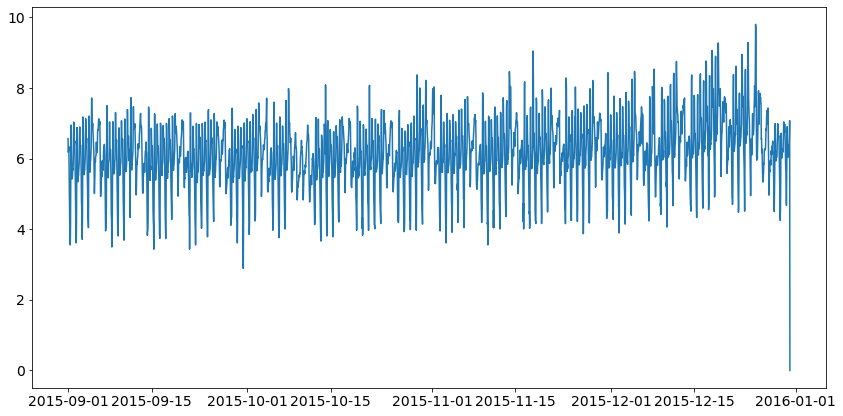

In [4]:
data = np.log(df['requests'])

plt.plot(data)

# Differencing

- Unit is s: in our case, a difference of 24 will translate to a seasonal difference order of 1

0.0007021437277726187
Data already stationary


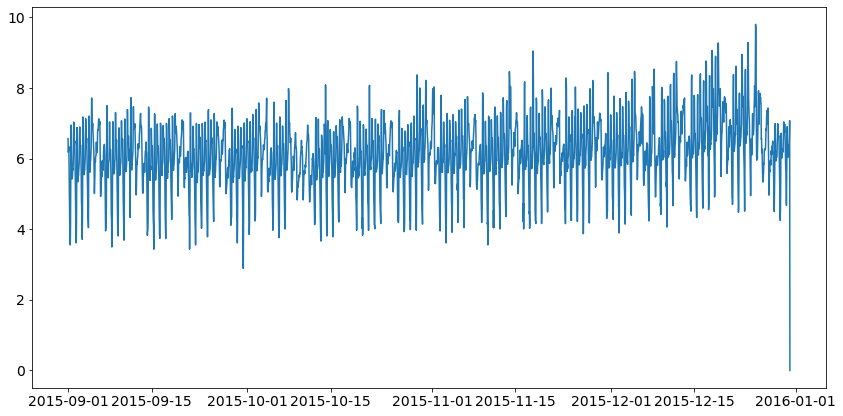

In [17]:
def adf_test(timeseries):   
    dftest = adfuller(timeseries, autolag='AIC')   # fail to reject H0: TS is non-stationary - time structure exists
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print (dfoutput) 
    return dfoutput

def makeStationary(df):
    d=-1
    temp = df
    for i in range(10):
        pvalue = adf_test(temp)[1]           # stationary
        if pvalue<=0.05:
            d=i
            return temp, d
        else:
            temp = difference(temp,i+1)
    if d==-1:
        print("Something's wrong")
        return -1, -1

def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    diff = pd.DataFrame(index=index[:len(diff)],data=diff, columns=['requests'])
    return diff, index

# Instead of inverse differencing everything, we do SARIMAX with d, D as discovered! Easier 
def invSDiff(orig_data, diff_data, interval):
    print(orig_data.shape, diff_data.shape)
    index = list(diff_data.index)
    diff_data = np.array(diff_data)
    orig_data = np.array(orig_data)
    datalist = [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]
    print(len(datalist)==len(diff_data))
    return pd.DataFrame(index=index, data=datalist, columns=['requests'])

if adf_test(data)[1]>0.05:
    print("Data is non stationary: applying differcing")
    data, index = difference(data, 1)
    d=0
else:
    print(adf_test(data)[1])
    print("Data already stationary")

plt.plot(data)
plt.show()

# Seasonal Differencing

- We have a stong autocorrelation on lags (24/48 etc) - we will do seasonal differencing

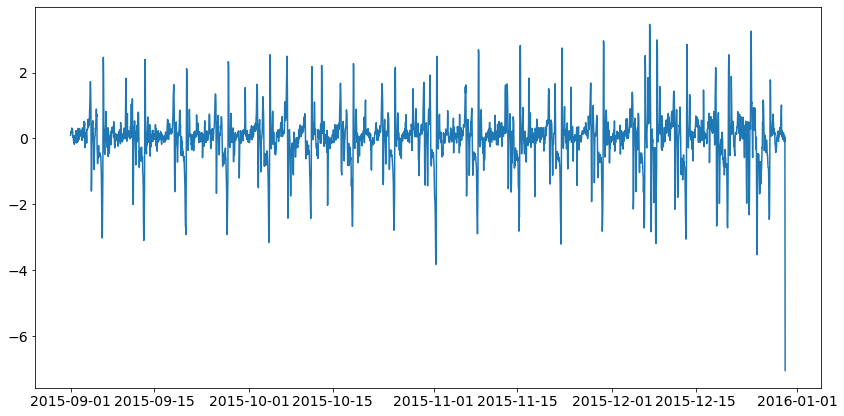

In [18]:
diffData, index = difference(data, 24)
D=1

plt.plot(diffData)

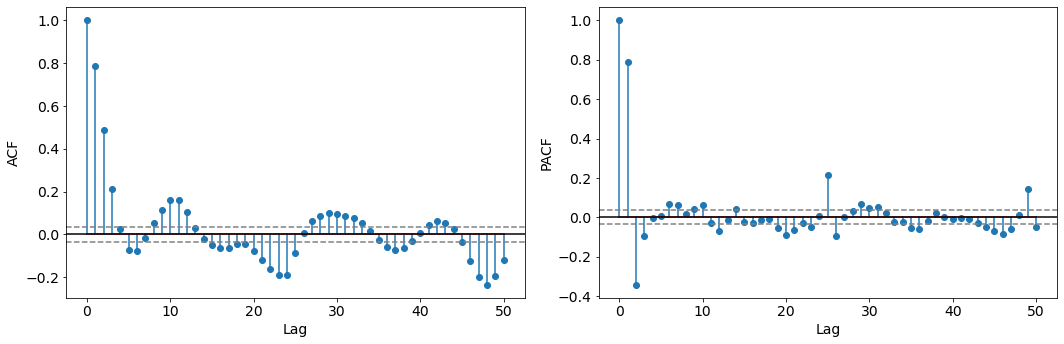

In [20]:
lag_acf = acf(diffData, nlags=50)
lag_pacf = pacf(diffData, nlags=50)

# Plot ACF:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
plt.xlabel('Lag')
plt.ylabel('ACF')


# Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

# Modeling

In [5]:
p = 2 
q = 3
s = 24 # big significant lag at lag 24 of acf
       # also since the lag is positive, it suggests P=1, Q=0
d = 0  # TS seems stationary, no need to difference
P = 3  # linearly decaying positive significant lags every s(24)
Q = 1  # single significant spike at lag s(24)
D = 1

stepsOut = 125

train = data[:-(stepsOut)]
test = data[-(stepsOut):]

exog = df[['Temperature', 'Precipitation', 'WindSpeed']]
exog_train = exog[:-(stepsOut)]
exog_test = exog[-(stepsOut):] 

## 5 SARIMAX

In [ ]:
def scoreSARIMAX(train, exog_train, params):
    model = SARIMAX(train, order=params[:3], seasonal_order=params[3:], freq='h', exog=exog_train)
    results = model.fit(disp=False, start_ar_lags=13)
    return (params, results.aic)

In [ ]:
# grid search configs
def GridSearchSARIMAX(train, exog_train):
    p = range(0, 3)
    d = range(0, 2)
    q = range(0, 2)  # q>1 causes error: The computed initial MA coefficients are not invertible,...
    P = range(0, 2)
    D = range(0, 2)
    Q = range(0, 2)
    s = range(24, 25)
    pdq = list(itertools.product(p, d, q, P, D, Q, s))
    scores = None
    
    # execute configs in parallel
    print("Starting GridSearch for best hyperparameters, evaluating "+str(len(pdq))+" models")
    executor = Parallel(n_jobs=-1, backend='threading')
    tasks = (delayed(scoreSARIMAX)(train, exog_train, cfg) for cfg in pdq)
    scores = executor(tasks)

    # remove empty results
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    print("Lowest score is "+str(scores[0][1])+", using parameters "+str(scores[0][0]))
    return scores[0][0]

Train MAE is: 171.30139119284885
Test MAE is: 513.2380421890567


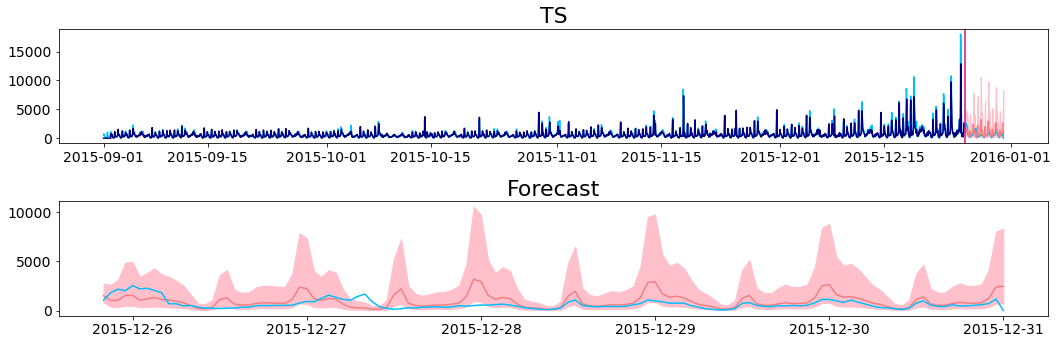

In [6]:
# GridSearchCV
bp = GridSearchSARIMAX(train, exog_train)

# Fit best model
p,d,q,P,D,Q,s = bp[0], bp[1], bp[2], bp[3], bp[4], bp[5], bp[6]
model = SARIMAX(train, order=(p,d,q),seasonal_order=(P,D,Q,s), exog=exog_train)  
result = model.fit(disp=False)
#print(result.summary())
trainpreds = result.fittedvalues
testpreds = result.predict(start=test.index[0], end=test.index[0-1], exog=exog_test)
ci = result.get_prediction(start=data.index[len(train)], end=data.index[len(data)-1] , exog=exog_test).conf_int()
low = ci['lower requests']
up = ci['upper requests']

# Inverse scale
dataRescaled = np.exp(data)
trainRescaled = np.exp(train)
testRescaled = np.exp(test)
trainpredsRescaled = np.exp(trainpreds)
testpredsRescaled = np.exp(testpreds)
lowRestored = np.exp(low)
upRestored = np.exp(up)

# Evaluate
score = mean_absolute_error(trainRescaled, trainpredsRescaled)
print("Train MAE is: "+str(score))
score = mean_absolute_error(testRescaled, testpredsRescaled)
print("Test MAE is: "+str(score))

# Plot
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(dataRescaled, color='deepskyblue')
plt.plot(trainpredsRescaled, color='navy')
plt.plot(testpredsRescaled, color='lightcoral')
plt.title('TS')
plt.axvline(x=test.index[0], label='train/test split', c='mediumvioletred')
plt.subplot(212)
plt.plot(testpredsRescaled, color='lightcoral')
plt.plot(testRescaled, color='deepskyblue')
plt.fill_between(test.index, lowRestored, upRestored, color='pink')
plt.title('Forecast')
plt.show()

In [ ]:
residuals = [test[i]-testpreds[i] for i in range(len(testpreds))]
sns.distplot(residuals)

# 5b SARIMAX Evaluate residuals

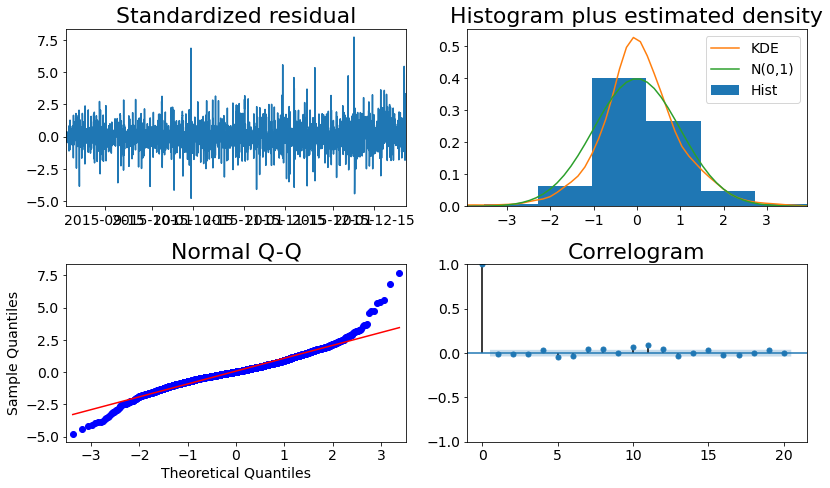

In [7]:
result.plot_diagnostics(figsize = (12, 7), lags=20);

# MISC

- If diff_1 IS stationary, we can either do ARMA on it, or ARIMA (with 1 level of integration: d=1) to the initial TS
- It is 100% equivalent BUT in the former we would have to un-difference our predictions (and train/test)